In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import script.common




조사년도
2023    389
2022    389
2021    388
2020    388
2019    386
Name: count, dtype: int64

C:\Users\fenpon\AppData\Local\Temp\ipykernel_33352\706317640.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_data[school_data['DistanceToCenter']  < originDistance[school_data['cluster']]]['DistanceToCenter'] = school_data['DistanceToCenter'] * -1
C:\Users\fenpon\AppData\Local\Temp\ipykernel_33352\706317640.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_data[school_data['DistanceToCenter']  >= originDistance[school_data['cluster']]]['DistanceToCenter'] = school_data['DistanceToCente

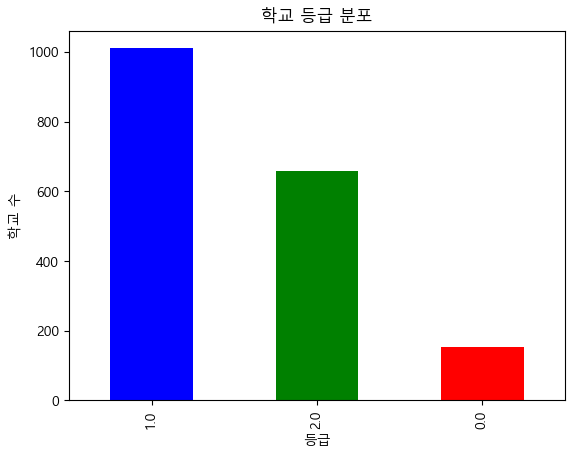

In [2]:



# Set font to avoid issues with displaying Korean characters
plt.rcParams['font.family'] = 'Malgun Gothic'  # For Windows, use 'AppleGothic' for macOS
plt.rcParams['axes.unicode_minus'] = False

# Load the data from uploaded files
jinak_su_data_path = './data/education/유치원초중고 진학수및 취업수 통계 자료 2019_2024 (1).csv'
location_data_path = './data/education/초중고위치데이터_위도_경도.csv'
facility_data_path = './data/education/유치원초중고 시설정보 2019_2024.csv'
updated_facility_data_path = './data/education/유치원초중고 시설정보 2019_2024.csv'

jinak_su_data = pd.read_csv(jinak_su_data_path)
location_data = pd.read_csv(location_data_path)
facility_data = pd.read_csv(facility_data_path)
updated_facility_data = pd.read_csv(updated_facility_data_path)
jinak_su_data = jinak_su_data[jinak_su_data['시도명'] == '서울']
display(jinak_su_data[jinak_su_data['학제유형명'].str.contains('중학교') & (jinak_su_data['특수목적고등학교진학학생수'] == 0)]['조사년도'].value_counts())
# Step 1: Filter data for high schools and calculate ratio of students progressing to colleges and facility score

# Step 2: Use facility information to grade middle schools with total facility score only
school_datas = []
for nn in [
        ('고등학교',['총시설점수', '진학률'])
    ]:
    (now, trainTag) = nn
    school_data = facility_data[facility_data['학교급명'].str.contains(now)].copy()  # 시설 데이터 필터링
    school_data = school_data[['학교명', '교사_학교사옥면적', '체육공간수', '교사_도서관수']]  # 필요한 컬럼만 선택
    
    # facility data merge
    school_data = pd.merge(jinak_su_data[jinak_su_data['학제유형명'].str.contains(now)],
                           school_data, how='left', on='학교명')
    
    # NaN 값 처리
    school_data[['체육공간수', '교사_도서관수']] = school_data[['체육공간수', '교사_도서관수']].fillna(0)
    
    # 총시설점수 계산
    school_data['총시설점수'] = school_data[['체육공간수', '교사_도서관수']].sum(axis=1)
    


    scaler = MinMaxScaler()
    school_data['총시설점수'] = scaler.fit_transform(school_data[['총시설점수']])
    
    if now == '고등학교':
        school_data['진학률'] = school_data['국내대학진학학생수'] / school_data['진학학생수'].replace(0, np.nan)  # 0으로 나누는 오류 방지
        school_data['진학률'] = scaler.fit_transform(school_data[['진학률']])
        school_data['진학률'] = school_data['진학률'].fillna(0)  # NaN 값 처리   
        school_data = school_data.drop(school_data[school_data['진학률'] == 0].index) 

    kmeans = KMeans(n_clusters=3, random_state=0)
    
    school_data['cluster'] = kmeans.fit_predict(school_data[trainTag].fillna(0))  # NaN 처리 후 클러스터링
    centroids = kmeans.cluster_centers_# 유클리드 거리 계산
    school_data['DistanceToCenter'] = school_data.apply(
        lambda row: np.linalg.norm(row[trainTag] - centroids[row['cluster']]),  # 유클리드 거리 계산
        axis=1
    )
    originDistance = np.linalg.norm(centroids, axis=1)
    classLevels = np.argsort(originDistance)[::-1]  # 내림차순 정렬

    # cluster와 classLevels 비교 후, 특정 열 업데이트
    for i, idx in enumerate(classLevels):
        school_data.loc[school_data['cluster'] == idx, '등급'] = int(i)   # 클래스 레벨 할당

    school_data[school_data['DistanceToCenter']  < originDistance[school_data['cluster']]]['DistanceToCenter'] = school_data['DistanceToCenter'] * -1
    school_data[school_data['DistanceToCenter']  >= originDistance[school_data['cluster']]]['DistanceToCenter'] = school_data['DistanceToCenter'] * 1


    school_data["score"] = school_data['DistanceToCenter'] + originDistance[school_data['cluster']]
    school_datas.append(school_data)


# Step 4: Merge location data with graded schools (high schools, middle schools, and elementary schools)


# Merge with location data to get latitude and longitude



# Exclude schools with missing latitude or longitude


# Plot distribution of grades
grade_counts = school_datas[0]['등급'].value_counts()

grade_counts.plot(kind='bar', color=['blue', 'green', 'red'])
plt.xlabel('등급')
plt.ylabel('학교 수')
plt.title('학교 등급 분포')
plt.show()



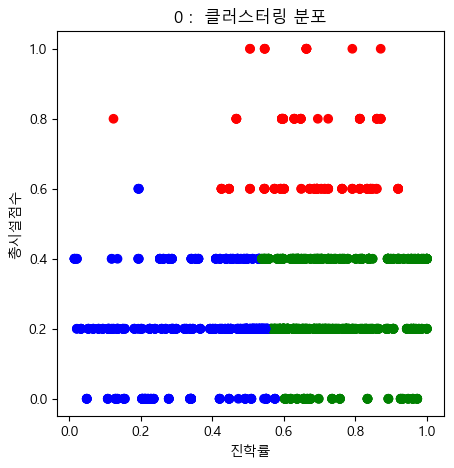

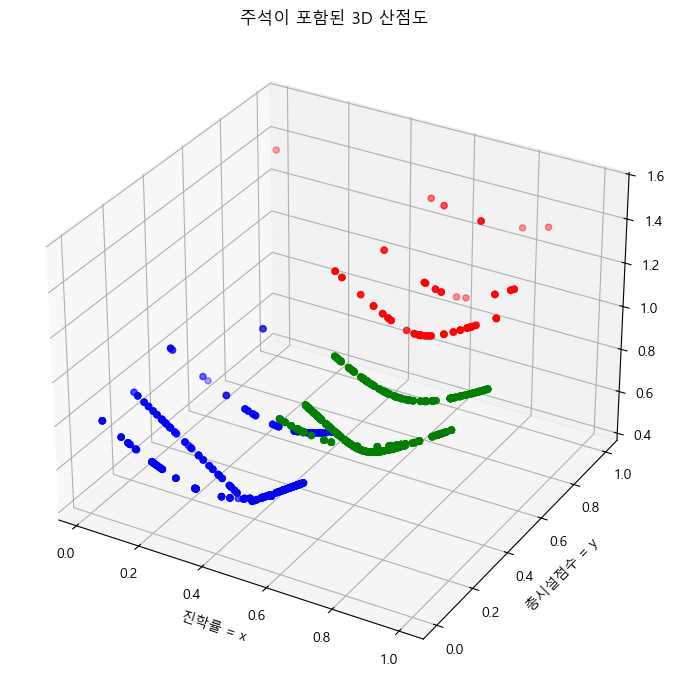

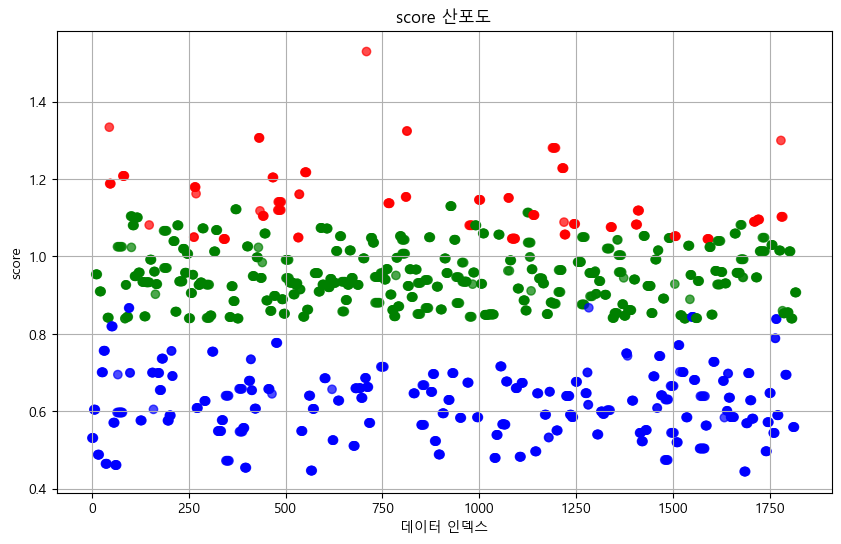

<Figure size 640x480 with 0 Axes>

In [3]:




fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
colors = ['r','g','b']
# High school clustering distribution


i = 0
axes.scatter(school_datas[i]['진학률'].fillna(0), school_datas[i]['총시설점수'], c=[colors[int(cls) ] for cls in school_datas[i]['등급']])
axes.set_xlabel('진학률')
axes.set_ylabel('총시설점수')
axes.set_title(f'{i} :  클러스터링 분포')



for i in range(0,1):
    color_map = [colors[int(cls) ] for cls in school_datas[i]['등급']]  # 클래스가 1부터 시작하므로 -1
    script.common.look3D(school_datas[i], ['진학률', '총시설점수'], [], color_map,'학교명')
for i in range(0,1):
    color_map = [colors[int(cls)] for cls in school_datas[i]['등급']]  # 클래스가 1부터 시작하므로 -1
    script.common.lookOne(school_datas[i],'score',color_map)
    

plt.tight_layout()
plt.show()


In [4]:
graded_schools = pd.concat([
    school_datas[0]
])
final_data = pd.merge(graded_schools, location_data, how='left', on='학교명')

display(final_data)
# Save the final result to a CSV file
output_path = './export/education/final_graded_school_locations.csv'
final_data.to_csv(output_path, index=False, encoding='utf-8') 


,조사년도,개방ID,학교명,학교급명,시도명,학제유형명,유초중등학생_학생수,초등과정졸업생수,중등과정졸업생수,고등과정졸업생수,...,입시전후기구분명,주야구분명,설립일자,개교기념일,시도교육청코드,시도교육청명,소재지명,적재일시,lat,lon
0,2019,1018780291,가재울고등학교,해당없음,서울,일반고등학교,693,0,0,0,...,후기,주간,20130301.0,20130501.0,B10,서울특별시교육청,서울특별시,20230615.0,37.574364,126.909530
1,2019,1018780291,가재울고등학교,해당없음,서울,일반고등학교,693,0,0,0,...,후기,주간,20130301.0,20130501.0,B10,서울특별시교육청,서울특별시,20230615.0,37.574364,126.909530
2,2019,1018780291,가재울고등학교,해당없음,서울,일반고등학교,693,0,0,0,...,후기,주간,20130301.0,20130501.0,B10,서울특별시교육청,서울특별시,20230615.0,37.574364,126.909530
3,2019,1018780291,가재울고등학교,해당없음,서울,일반고등학교,693,0,0,0,...,후기,주간,20130301.0,20130501.0,B10,서울특별시교육청,서울특별시,20230615.0,37.574364,126.909530
4,2019,1018780291,가재울고등학교,해당없음,서울,일반고등학교,693,0,0,0,...,후기,주간,20130301.0,20130501.0,B10,서울특별시교육청,서울특별시,20230615.0,37.574364,126.909530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,2019,9987677931,동일여자고등학교,해당없음,서울,일반고등학교,664,0,0,0,...,후기,주간,19721219.0,19680910.0,B10,서울특별시교육청,서울특별시,20230615.0,37.451921,126.915824
1816,2019,9987677931,동일여자고등학교,해당없음,서울,일반고등학교,664,0,0,0,...,후기,주간,19721219.0,19680910.0,B10,서울특별시교육청,서울특별시,20230615.0,37.451921,126.915824
1817,2019,9987677931,동일여자고등학교,해당없음,서울,일반고등학교,664,0,0,0,...,후기,주간,19721219.0,19680910.0,B10,서울특별시교육청,서울특별시,20230615.0,37.451921,126.915824
1818,2019,9987677931,동일여자고등학교,해당없음,서울,일반고등학교,664,0,0,0,...,후기,주간,19721219.0,19680910.0,B10,서울특별시교육청,서울특별시,20230615.0,37.451921,126.915824
